In [10]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### 1. 데이터 로드 및 코호트 분석을 위한 날짜 변수 생성

In [11]:
df= pd.read_excel('C:/Users/Park/_Python_data/relay-foods.xlsx', sheet_name='Purchase Data - Full Study')

df['OrderMonth'] = df.OrderDate.apply(lambda x : datetime.strftime(x, '%Y-%m'))      # strftime : 날짜형을 문자형으로 변환            
                                                                                      # srtptime : 문자형을 날짜형으로 변환
df

,OrderId,OrderDate,UserId,TotalCharges,CommonId,PupId,PickupDate,OrderMonth
0,262,2009-01-11,47,50.6700,TRQKD,2,2009-01-12,2009-01
1,278,2009-01-20,47,26.6000,4HH2S,3,2009-01-20,2009-01
2,294,2009-02-03,47,38.7100,3TRDC,2,2009-02-04,2009-02
3,301,2009-02-06,47,53.3800,NGAZJ,2,2009-02-09,2009-02
4,302,2009-02-06,47,14.2800,FFYHD,2,2009-02-09,2009-02
...,...,...,...,...,...,...,...,...
2886,3220,2010-03-08,393616,60.0155,AWNXG,15,2010-03-08,2010-03
2887,3192,2010-03-07,394290,45.4300,AKGQT,12,2010-03-10,2010-03
2888,3193,2010-03-07,394346,14.2100,2B47R,15,2010-03-08,2010-03
2889,3207,2010-03-08,395039,34.6200,H6E23,4,2010-03-08,2010-03


### 2. 코호트 분석에 필요한 데이터 전처리

      1) 피벗테이블을 활용하여 고객 아이디별 구매일자/구매 월/ 구매 주 데이터 추출
      2) 고객 아이디별 최초 구매일자 -> 가입일자 추출
      3) 2)에서 추출한 최초 가입일자를 본 데이터와 결합
      4) 최초 가입일자를 기준으로 경과시간 변수 추가

#### 1) 고객 아이디별 구매일자/구매 월 데이터 추출

In [12]:
cohort_df = df.pivot_table(index = ['OrderMonth','OrderDate','UserId'], values = 'TotalCharges',aggfunc='count')
cohort_df = cohort_df.reset_index()
cohort_df

,OrderMonth,OrderDate,UserId,TotalCharges
0,2009-01,2009-01-06,253,1
1,2009-01,2009-01-06,1558,1
2,2009-01,2009-01-06,3190,1
3,2009-01,2009-01-06,3194,1
4,2009-01,2009-01-11,47,1
...,...,...,...,...
2780,2010-03,2010-03-08,380119,1
2781,2010-03,2010-03-08,393616,1
2782,2010-03,2010-03-08,395039,1
2783,2010-03,2010-03-08,396551,1


#### 2) 고객 아이디별 최초 구매일자  추출

- 가정 : 가장 오래된 시점을 첫 번째 신규 고객 가입 시점이라 가정
- 고객 아이디와 주문일자 기준으로 정렬 후 최초 구매일자를 제외한 데이터 제거

In [13]:
cohort_df = cohort_df.sort_values(by=['OrderDate','OrderDate'])
## 고객 id별 중복을 삭제하여 최초 구매시점의 데이터를 제외한 나머지 삭제 ##
cohort_df = cohort_df.drop_duplicates(subset = ['UserId'])
## 컬럼명 변경
cohort_df.columns = ['CohortGroup','JoinDate','UserId','x']
cohort_df

,CohortGroup,JoinDate,UserId,x
0,2009-01,2009-01-06,253,1
1,2009-01,2009-01-06,1558,1
2,2009-01,2009-01-06,3190,1
3,2009-01,2009-01-06,3194,1
4,2009-01,2009-01-11,47,1
...,...,...,...,...
2753,2010-03,2010-03-07,394290,1
2754,2010-03,2010-03-07,394346,1
2781,2010-03,2010-03-08,393616,1
2782,2010-03,2010-03-08,395039,1


#### 3) 최초 가입일자, 그룹별 최초 가입자, 그룹별 주문횟수 등 본 데이터와 결합

In [14]:
cohort_df = pd.merge(df, cohort_df, how = 'left', on = ['UserId'])
cohort_df = cohort_df[['CohortGroup','JoinDate','OrderMonth','OrderDate','UserId','OrderId','TotalCharges']]
cohort_df

,CohortGroup,JoinDate,OrderMonth,OrderDate,UserId,OrderId,TotalCharges
0,2009-01,2009-01-11,2009-01,2009-01-11,47,262,50.6700
1,2009-01,2009-01-11,2009-01,2009-01-20,47,278,26.6000
2,2009-01,2009-01-11,2009-02,2009-02-03,47,294,38.7100
3,2009-01,2009-01-11,2009-02,2009-02-06,47,301,53.3800
4,2009-01,2009-01-11,2009-02,2009-02-06,47,302,14.2800
...,...,...,...,...,...,...,...
2886,2010-03,2010-03-08,2010-03,2010-03-08,393616,3220,60.0155
2887,2010-03,2010-03-07,2010-03,2010-03-07,394290,3192,45.4300
2888,2010-03,2010-03-07,2010-03,2010-03-07,394346,3193,14.2100
2889,2010-03,2010-03-08,2010-03,2010-03-08,395039,3207,34.6200


#### 4) 최초 가입일자를 기준으로 경과시간 변수 추가

In [15]:
month_dict= {}
i = 0

for month in sorted(df.OrderMonth.unique()):
    month_dict[month] = i
    i += 1

cohort_df['Period_month'] = cohort_df.OrderMonth.apply(lambda x : month_dict[x]) - cohort_df.CohortGroup.apply(lambda x : month_dict[x])
cohort_df

,CohortGroup,JoinDate,OrderMonth,OrderDate,UserId,OrderId,TotalCharges,Period_month
0,2009-01,2009-01-11,2009-01,2009-01-11,47,262,50.6700,0
1,2009-01,2009-01-11,2009-01,2009-01-20,47,278,26.6000,0
2,2009-01,2009-01-11,2009-02,2009-02-03,47,294,38.7100,1
3,2009-01,2009-01-11,2009-02,2009-02-06,47,301,53.3800,1
4,2009-01,2009-01-11,2009-02,2009-02-06,47,302,14.2800,1
...,...,...,...,...,...,...,...,...
2886,2010-03,2010-03-08,2010-03,2010-03-08,393616,3220,60.0155,0
2887,2010-03,2010-03-07,2010-03,2010-03-07,394290,3192,45.4300,0
2888,2010-03,2010-03-07,2010-03,2010-03-07,394346,3193,14.2100,0
2889,2010-03,2010-03-08,2010-03,2010-03-08,395039,3207,34.6200,0


### 2. 코호트 데이터 시각화

#### 1) 매출액 retention

In [16]:
charges_reten = cohort_df.pivot_table(index = 'CohortGroup', columns = 'Period_month', values = 'TotalCharges', aggfunc = 'sum')
charges_reten

Period_month,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
CohortGroup,,,,,,,,,,,,,,,
2009-01,1850.2550,1351.0650,1357.3600,1604.5000,1575.6250,1384.8400,1750.8400,1426.5714,1964.2755,860.3292,1821.8153,2152.1165,2084.2236,2068.7771,1504.3325
2009-02,666.3100,501.6100,968.7800,53.3600,758.5200,667.1000,314.1752,567.5057,328.2800,738.9359,263.1971,550.0098,734.7613,NaN,NaN
2009-03,806.3100,463.8000,1108.2100,902.7100,161.2500,1010.8000,1256.4672,1067.9247,905.3610,485.9966,897.1602,642.1517,76.3100,NaN,NaN
2009-04,2561.2500,1189.5800,1085.3800,987.1300,474.0100,531.3825,209.4465,339.1139,147.3250,445.5447,634.6950,279.8733,NaN,NaN,NaN
2009-05,2627.5600,1146.8300,648.2100,381.1500,415.5969,389.0605,351.6800,420.2842,223.5689,613.8222,81.8283,NaN,NaN,NaN,NaN
2009-06,1544.2200,1165.9000,688.2129,922.7762,504.4159,182.9100,295.0000,514.9887,1211.4755,162.1200,NaN,NaN,NaN,NaN,NaN
2009-07,2797.7600,1858.3499,1312.8502,1053.5599,833.4690,506.2409,793.0552,1163.1282,401.7190,NaN,NaN,NaN,NaN,NaN,NaN
2009-08,2605.9981,1869.4376,1313.7691,1228.7399,1723.3975,1213.1379,1595.9906,478.7787,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-09,1953.0553,2433.3013,1953.2262,1371.3499,2262.0346,1842.9434,688.6822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
charges_reten_rate=charges_reten.copy()

for col in charges_reten.columns :
    charges_reten_rate[col] = charges_reten_rate[col] / charges_reten[0]
charges_reten_rate

Period_month,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
CohortGroup,,,,,,,,,,,,,,,
2009-01,1.0,0.730205,0.733607,0.867178,0.851572,0.748459,0.946270,0.771013,1.061624,0.464979,0.984629,1.163146,1.126452,1.118104,0.813041
2009-02,1.0,0.752818,1.453948,0.080083,1.138389,1.001186,0.471515,0.851714,0.492684,1.108997,0.395007,0.825456,1.102732,NaN,NaN
2009-03,1.0,0.575213,1.374422,1.119557,0.199985,1.253612,1.558293,1.324459,1.122845,0.602742,1.112674,0.796408,0.094641,NaN,NaN
2009-04,1.0,0.464453,0.423770,0.385409,0.185070,0.207470,0.081775,0.132402,0.057521,0.173956,0.247807,0.109272,NaN,NaN,NaN
2009-05,1.0,0.436462,0.246697,0.145059,0.158168,0.148069,0.133843,0.159952,0.085086,0.233609,0.031142,NaN,NaN,NaN,NaN
2009-06,1.0,0.755009,0.445670,0.597568,0.326648,0.118448,0.191035,0.333494,0.784523,0.104985,NaN,NaN,NaN,NaN,NaN
2009-07,1.0,0.664228,0.469250,0.376573,0.297906,0.180945,0.283461,0.415736,0.143586,NaN,NaN,NaN,NaN,NaN,NaN
2009-08,1.0,0.717360,0.504133,0.471505,0.661320,0.465518,0.612430,0.183722,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-09,1.0,1.245895,1.000088,0.702156,1.158203,0.943621,0.352618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='Period_month', ylabel='CohortGroup'>

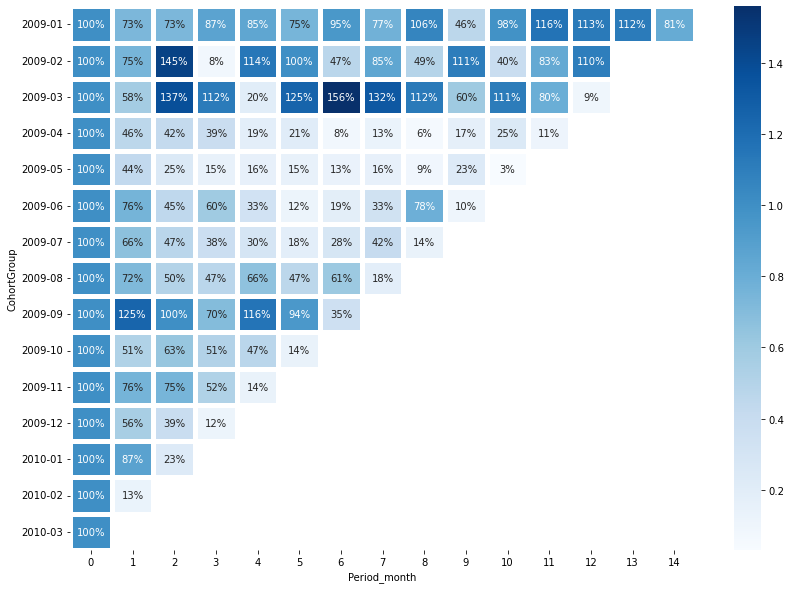

In [18]:
plt.figure(figsize=(14,10))
sns.heatmap(charges_reten_rate, annot=True, fmt='.0%', linewidth=5, cmap = 'Blues')

#### 2) 가입고객 retention

- cohort_df 데이터에서 ordermonth와 userid의 중복값을 제거하여 코호트 집단별 월별 고객 주문 횟수를 출력한다

In [19]:
cohort_user = cohort_df.drop_duplicates(subset = ['OrderMonth','UserId'])
user_reten = cohort_user.pivot_table(index= 'CohortGroup',columns  =  'Period_month', values = 'UserId',aggfunc='count')
user_reten

Period_month,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
CohortGroup,,,,,,,,,,,,,,,
2009-01,22.0,8.0,10.0,9.0,10.0,8.0,8.0,7.0,7.0,7.0,7.0,8.0,11.0,7.0,6.0
2009-02,15.0,3.0,5.0,1.0,4.0,4.0,4.0,5.0,5.0,4.0,3.0,3.0,5.0,NaN,NaN
2009-03,13.0,4.0,5.0,4.0,1.0,2.0,2.0,3.0,2.0,1.0,3.0,2.0,1.0,NaN,NaN
2009-04,39.0,13.0,10.0,13.0,6.0,7.0,4.0,6.0,2.0,4.0,3.0,2.0,NaN,NaN,NaN
2009-05,50.0,13.0,12.0,5.0,4.0,6.0,3.0,5.0,5.0,4.0,3.0,NaN,NaN,NaN,NaN
2009-06,32.0,15.0,9.0,6.0,7.0,5.0,3.0,3.0,10.0,3.0,NaN,NaN,NaN,NaN,NaN
2009-07,50.0,23.0,13.0,10.0,11.0,10.0,11.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN
2009-08,31.0,11.0,9.0,7.0,6.0,8.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-09,37.0,15.0,14.0,8.0,13.0,9.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
user_reten_rate = user_reten.copy()

for i in user_reten_rate.columns:
    user_reten_rate[i] = round(user_reten_rate[i] /user_reten[0],3)
user_reten_rate

Period_month,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
CohortGroup,,,,,,,,,,,,,,,
2009-01,1.0,0.364,0.455,0.409,0.455,0.364,0.364,0.318,0.318,0.318,0.318,0.364,0.500,0.318,0.273
2009-02,1.0,0.200,0.333,0.067,0.267,0.267,0.267,0.333,0.333,0.267,0.200,0.200,0.333,NaN,NaN
2009-03,1.0,0.308,0.385,0.308,0.077,0.154,0.154,0.231,0.154,0.077,0.231,0.154,0.077,NaN,NaN
2009-04,1.0,0.333,0.256,0.333,0.154,0.179,0.103,0.154,0.051,0.103,0.077,0.051,NaN,NaN,NaN
2009-05,1.0,0.260,0.240,0.100,0.080,0.120,0.060,0.100,0.100,0.080,0.060,NaN,NaN,NaN,NaN
2009-06,1.0,0.469,0.281,0.188,0.219,0.156,0.094,0.094,0.312,0.094,NaN,NaN,NaN,NaN,NaN
2009-07,1.0,0.460,0.260,0.200,0.220,0.200,0.220,0.140,0.140,NaN,NaN,NaN,NaN,NaN,NaN
2009-08,1.0,0.355,0.290,0.226,0.194,0.258,0.129,0.129,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-09,1.0,0.405,0.378,0.216,0.351,0.243,0.216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='Period_month', ylabel='CohortGroup'>

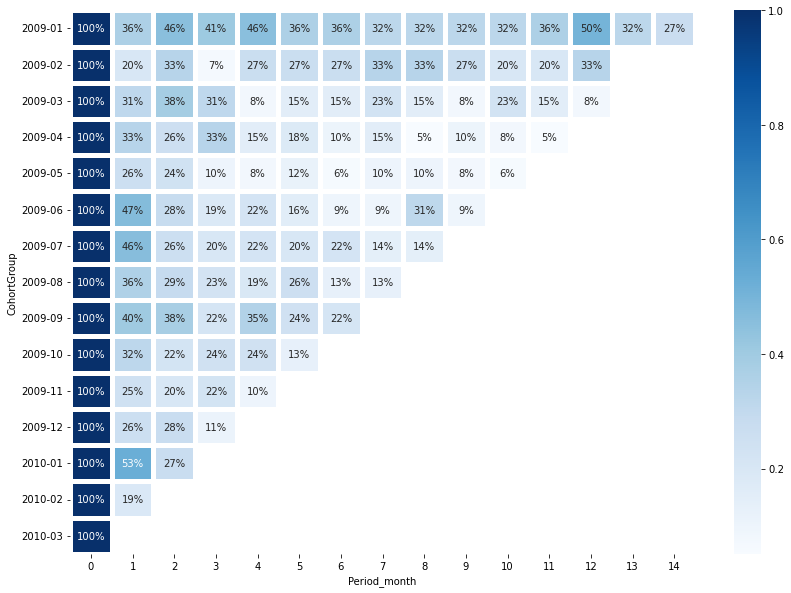

In [21]:
plt.figure(figsize=(14,10))
sns.heatmap(user_reten_rate , annot=True, fmt='.0%', linewidth=5, cmap = 'Blues')

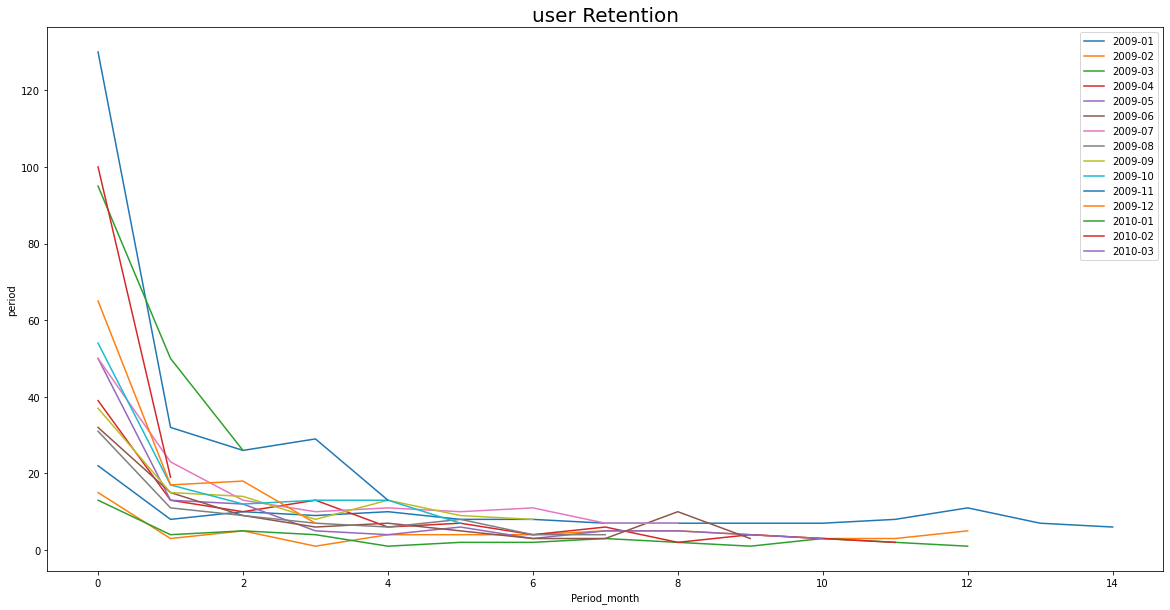

In [22]:
plt.figure(figsize=(20,10))
plt.title('user Retention',fontsize=20)
plt.xlabel('user')
plt.ylabel('period')

for i in user_reten.T.columns:
    user_reten.T[i].plot()
    plt.legend()